## Weboldalak újralátogatásának modellezése

K-karú rabló Gamma-Poisson modell felhasználásával + dinaimikus kiterjesztés.

In [1]:
%pylab inline

from scipy.special import gammaln

Populating the interactive namespace from numpy and matplotlib


\begin{align}
p\left(k \mid \lambda \right) &= e^{-\lambda} \frac{\lambda^k}{k!} \\
p\left(\lambda \mid \alpha, \beta \right) &= \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta \lambda} \\
p\left( \lambda \mid \alpha, \beta, k \right) &\propto p\left(k\mid \lambda \right) p\left(\lambda \mid \alpha, \beta \right) \\
&\propto e^{-\lambda} \lambda^k \lambda^{\alpha-1} e^{-\beta \lambda} \\
&= \lambda^{\alpha+k-1} e^{-(\beta+1)\lambda} \\
p\left(\lambda \mid \alpha, \beta, k \right) &= \mathcal{G}a \left(\lambda \mid \alpha+k, \beta+1\right)
\end{align}

In [2]:
class ThompsonSampler:
    def __init__(self,K):
        self.X = []
        self.A = []
        self.K = K
        self.a = np.ones(K)
        self.b = np.ones(K)

    def choose(self):
        return np.argmax(np.random.gamma(self.a,1./self.b))

    def update(self,a,k):
        self.A += [a]
        self.X += [k]
        self.a[a] += k
        self.b[a] += 1

In [3]:
class DynamicThompsonSampler:
    def __init__(self,K,p):
        self.X = []
        self.A = []
        self.K = K
        self.p = p
        
        self.a = [[0,1] for k in range(K)]
        self.b = [[0,1] for k in range(K)]
        self.l = np.ones(K,dtype=np.int)*2

    def choose(self):
        s = np.maximum(self.l - np.random.geometric(self.p,self.K) - 1,0)
        a = [self.a[k][-1]-self.a[k][s[k]] for k in range(self.K)]
        b = [1/(self.b[k][-1]-self.b[k][s[k]]) for k in range(self.K)]
        arm = np.argmax(np.random.gamma(a,b))
        return arm

    def update(self,a,k):
        self.A += [a]
        self.X += [k]
        self.a[a] += [self.a[a][-1] + k]
        self.b[a] += [self.b[a][-1] + 1]
        self.l[a] += 1

In [4]:
def simulate(p,agent,T=10000):
    for t in range(T):
        ch = agent.choose()
        k  = np.random.poisson(p[ch])
        agent.update(ch,k)

In [5]:
p = np.array([0.1,0.5,1.,5.,10.])/10

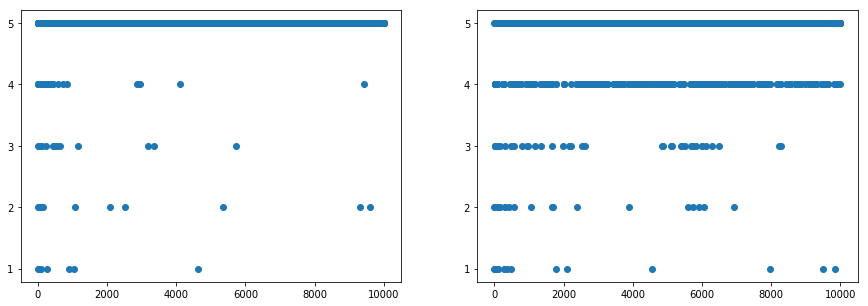

In [6]:
agents = [ThompsonSampler(len(p)),DynamicThompsonSampler(len(p),0.01)]
f,ax   = subplots(1,2)
f.set_size_inches(15,5)
for a in range(len(agents)):
    agent = agents[a]
    simulate(p,agent,10000)
    ax[a].scatter(np.arange(len(agent.A)),agent.A);
    ax[a].set_yticks(np.arange(5))
    ax[a].set_yticklabels(np.arange(5)+1)

In [7]:
np.sum(agents[0].X)

10014

In [8]:
np.sum(agents[1].X)

9821

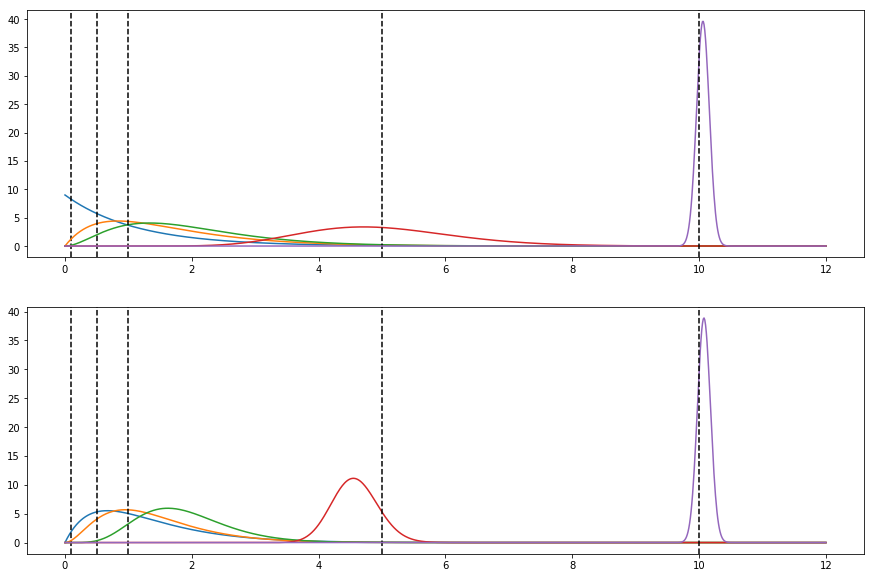

In [9]:
def log_prob(x,a,b):
    return a*np.log(b) - gammaln(a) + (a-1) * np.log(x) - b*x

def prob(x,a,b):
    return np.exp(log_prob(x,a,b))

f,ax = subplots(2,1)
f.set_size_inches(15,10)

x = np.linspace(0,1.2,1000) + 1e-12
for i in range(len(p)):
    ax[0].plot(x*10,prob(x,agents[0].a[i],agents[0].b[i]))
    ax[1].plot(x*10,prob(x,agents[1].a[i][-1],agents[1].b[i][-1]))
    ax[0].axvline(p[i]*10,c='black',ls='--')
    ax[1].axvline(p[i]*10,c='black',ls='--')

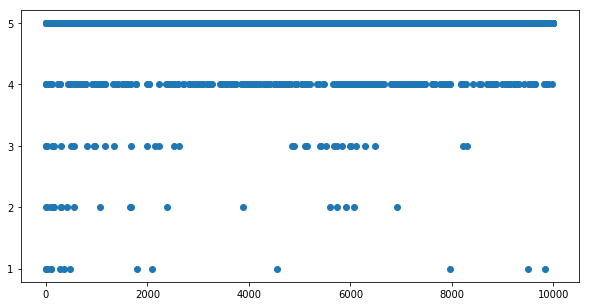

In [16]:
f,ax = subplots(1)
f.set_size_inches(10,5)
ax.scatter(np.arange(len(agents[1].A)),agents[1].A)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(np.arange(5)+1)

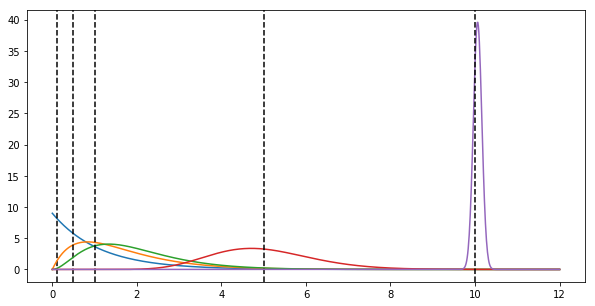

In [15]:
f,ax = subplots(1)
f.set_size_inches(10,5)

x = np.linspace(0,1.2,1000) + 1e-12
for i in range(len(p)):
    ax.plot(x*10,prob(x,agents[0].a[i],agents[0].b[i]))
    ax.axvline(p[i]*10,c='black',ls='--')

In [20]:
p1 = np.array([0.1,0.5,1.,5.,10.])/10
p2 = np.array([11.,0.5,1.,5.,10.])/10
agi = DynamicThompsonSampler(len(p),0.01)
simulate(p1,agi,5000)
simulate(p2,agi,5000)

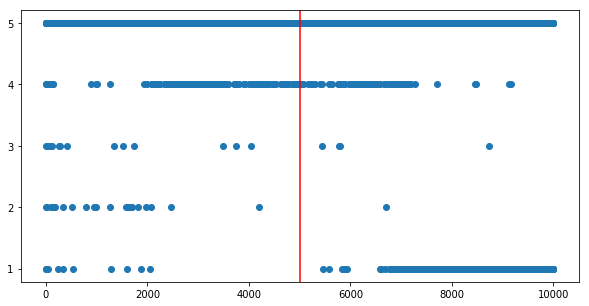

In [22]:
f,ax = subplots(1)
f.set_size_inches(10,5)
ax.scatter(np.arange(len(agi.A)),agi.A)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(np.arange(5)+1)
ax.axvline(5000,c='r')